- In the last project **i created a language model** based only on the **bigrams**, the idea was to **predict the next character of the sequence**, taking into account the previous character.

- For that project we will use an **MLP to handle this task**.

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [ ]:
# read in all the words
with  open('/content/names.txt',mode='r', encoding='utf-8') as f:
  words=f.read().split()

In [ ]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
len(words)

32033

# **1-Building our training dataset**

In [ ]:
chidx=[]
for word in words:
  for ch in word:
    if ch not in chidx:
      chidx.append(ch)

In [ ]:
vocab=sorted(chidx)
print(vocab,end='')

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [ ]:
# build the vocabulary of characters and mapping to /from integers
stoi ={s:i+1 for i , s in enumerate(vocab)}
stoi['.']=0
# reverse mapping
itos={i:s for  s,i in stoi.items()}

In [ ]:
print(itos, end='')

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}

In [ ]:
# build the dataset

block_size=3 #context length:how many characters do we take to predict the next  one

X,Y=[],[]

for w in words:

  #print(w)

  context=[0]*block_size

  for ch in w + '.':
    ix=stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(' '.join(itos[i] for i in context),'---------->',itos[ix])
    context=context[1:] + [ix]

X=torch.tensor(X)
Y=torch.tensor(Y)

# **2-Implementing the embedding lookup table**

In [ ]:
C=torch.randn([27,2])  # Starting the embedding erray with random numbers

In [ ]:
C.shape

torch.Size([27, 2])

In [ ]:
'''
As we have 27 categories .. we need to retrieve the rows from the embedding matrix..
To do this we can create a vector one_hot with (27,27)
'''
LT=F.one_hot(torch.arange(27),num_classes=27).float() @ C

- Another way we can do is to directly index the v**ector X in the embedding matrix**

In [ ]:
C[X][0,:]

tensor([[-0.4350,  0.4834],
        [-0.4350,  0.4834],
        [-0.4350,  0.4834]])

In [ ]:
emb=C[X]

In [ ]:
emb.shape

torch.Size([228146, 3, 2])

# **3-Implementing the hidden layer + internals of torch.Tensor: storage, views**

In [ ]:
w1=torch.randn(6,100)
b1=torch.randn(100)

- The embedding matrix is a tensor with **(B,T,D)** so we cannot perform a **matrix operation**...

- To do this, we're going to perform an **axis transposition.**

In [ ]:
emb.reshape(emb.shape[0],emb.shape[1]*emb.shape[2])[:5]

tensor([[-0.4350,  0.4834, -0.4350,  0.4834, -0.4350,  0.4834],
        [-0.4350,  0.4834, -0.4350,  0.4834,  0.7123,  0.4660],
        [-0.4350,  0.4834,  0.7123,  0.4660, -0.2186,  0.1526],
        [ 0.7123,  0.4660, -0.2186,  0.1526, -0.2186,  0.1526],
        [-0.2186,  0.1526, -0.2186,  0.1526, -0.8642,  0.9322]])

- Another way to do this is to use the **view operation**

In [ ]:
emb.view(emb.shape[0],emb.shape[1]*emb.shape[2])[:5]

tensor([[-0.4350,  0.4834, -0.4350,  0.4834, -0.4350,  0.4834],
        [-0.4350,  0.4834, -0.4350,  0.4834,  0.7123,  0.4660],
        [-0.4350,  0.4834,  0.7123,  0.4660, -0.2186,  0.1526],
        [ 0.7123,  0.4660, -0.2186,  0.1526, -0.2186,  0.1526],
        [-0.2186,  0.1526, -0.2186,  0.1526, -0.8642,  0.9322]])

In [ ]:
h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1 )

In [ ]:
w2=torch.randn(100,27)
b2=torch.randn(27)

In [ ]:
logits=h @ w2 + b2

In [ ]:
counts=logits.exp()

In [ ]:
probs=counts/counts.sum(1,keepdim=True)

In [ ]:
probs.shape

torch.Size([228146, 27])

#**4-implementing the negative log likelihood loss**

In [ ]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [ ]:
loss=-probs[torch.arange(Y.shape[0]),Y].log().mean()

# **5-Summary of the full network**

In [ ]:
g=torch.Generator().manual_seed(2134563788) # for reproducibility
C=torch.randn([27,2],requires_grad=True)
w1=torch.randn([6,100],requires_grad=True)
b1=torch.randn(100,requires_grad=True)
w2=torch.randn([100,27],requires_grad=True)
b2=torch.randn(27,requires_grad=True)
parameters=[C,w1,b1,w2,b2]

In [ ]:
sum(p.nelement() for p in parameters) # numbers of parameters in total

3481

# **6-implementing the training loop, overfitting one batch**

In [ ]:
steps=20

for k in range(steps):
  # forward pass
  emb=C[X] # (32,3,2)
  h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
  logits=h @ w2+b2 # (32,27)
  loss=F.cross_entropy(logits,Y)
  print(f'loss:{loss.item()},epochs:{k+1}')

  #  backward pass

  for  p  in parameters:
    p.grad=None

  loss.backward()

  #  update

  for p in parameters:
    p.data+=-0.1 * p.grad

loss:20.017545700073242,epochs:1
loss:17.685405731201172,epochs:2
loss:15.195794105529785,epochs:3
loss:14.302081108093262,epochs:4
loss:13.340991973876953,epochs:5
loss:12.605304718017578,epochs:6
loss:11.910996437072754,epochs:7
loss:11.36402416229248,epochs:8
loss:10.579933166503906,epochs:9
loss:10.025096893310547,epochs:10
loss:9.50571060180664,epochs:11
loss:9.038402557373047,epochs:12
loss:8.609878540039062,epochs:13
loss:8.225211143493652,epochs:14
loss:7.871665000915527,epochs:15
loss:7.556427001953125,epochs:16
loss:7.263383865356445,epochs:17
loss:7.002638339996338,epochs:18
loss:6.750802993774414,epochs:19
loss:6.524465084075928,epochs:20


In [ ]:
loss

tensor(6.5245, grad_fn=<NllLossBackward0>)

- Many times the data may not fit **in the memory**, a recommendation **is to use batches**..  In addition to being a **good approach**, it also **speeds up training considerably**

# **7-Training on the full dataset, minibatches**

In [ ]:
steps=10
for  k in range(steps):

  ix=torch.randint(0,X.shape[0],(32,))
  # forward pass
  emb=C[X[ix]] # (32,3,2)
  h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
  logits=h @ w2+b2 # (32,27)
  loss=F.cross_entropy(logits,Y[ix])
  print(f'loss:{loss.item()},epochs:{k+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  for p  in parameters:
    p.data+=-0.1*p.grad

loss:6.515289306640625,epochs:1
loss:6.496755599975586,epochs:2
loss:6.020139217376709,epochs:3
loss:4.830341339111328,epochs:4
loss:5.445677757263184,epochs:5
loss:5.187361240386963,epochs:6
loss:4.913257598876953,epochs:7
loss:5.95115852355957,epochs:8
loss:7.3996195793151855,epochs:9
loss:6.422539710998535,epochs:10


# **8-Finding a good initial learning rate**

- It is known that the **learning rate is essential** for us to always take **good steps in the right direction**

- However, we don't know what the best **learning rate is**.

- One of the ways to know this is by **experimentation**, testing various **learning rates** and finding out which one is **the best.**

- However, what happens when the **learning rate is too small?**

In [ ]:
steps=20
for  k in range(steps):

  ix=torch.randint(0,X.shape[0],(32,))
  # forward pass
  emb=C[X[ix]] # (32,3,2)
  h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
  logits=h @ w2+b2 # (32,27)
  loss=F.cross_entropy(logits,Y[ix])
  print(f'loss:{loss.item()},epochs:{k+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  for p  in parameters:
    p.data+=-0.0000001*p.grad

loss:3.8479089736938477,epochs:1
loss:5.273167610168457,epochs:2
loss:6.065744876861572,epochs:3
loss:4.877919673919678,epochs:4
loss:4.809784412384033,epochs:5
loss:4.57532262802124,epochs:6
loss:5.457077980041504,epochs:7
loss:5.416530132293701,epochs:8
loss:4.565851211547852,epochs:9
loss:4.878824234008789,epochs:10
loss:5.349943161010742,epochs:11
loss:6.193647384643555,epochs:12
loss:5.759314060211182,epochs:13
loss:6.0899763107299805,epochs:14
loss:4.689331531524658,epochs:15
loss:5.290650844573975,epochs:16
loss:6.598118305206299,epochs:17
loss:5.041703701019287,epochs:18
loss:5.981029987335205,epochs:19
loss:5.285632610321045,epochs:20


- When the **learning rate is too small**, the step we take in the right direction is too small. This causes the error to decrease very slowly


- In the same way, **when the learning rate is too long**, we can take too **big steps in the right direction**, but **this has its consequences**, we can go beyond the **minimum** of the function.**What we don't want**

- Certainly, there are many **ways to solve this problem**... One of the alternatives is to **create a linear spacing** , where each epoch we increase the learning rate a little by taking a small step between the **previous rate and the next**

In [ ]:
lre=torch.linspace(-3,0,10000)
lrs=100**lre
lrs[:10]

tensor([1.0000e-06, 1.0014e-06, 1.0028e-06, 1.0042e-06, 1.0055e-06, 1.0069e-06,
        1.0083e-06, 1.0097e-06, 1.0111e-06, 1.0125e-06])

In [ ]:
lri=[]
lossi=[]

steps=10000
for  i in range(steps):

  ix=torch.randint(0,X.shape[0],(32,))
  # forward pass
  emb=C[X[ix]] # (32,3,2)
  h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
  logits=h @ w2+b2 # (32,27)
  loss=F.cross_entropy(logits,Y[ix])
  loss
  #print(f'loss:{loss.item()},epochs:{i+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  lr=lrs[i]
  for p  in parameters:
    p.data+=-lr*p.grad

    # strack stats
  lri.append(lre[i])
  lossi.append(loss.item())

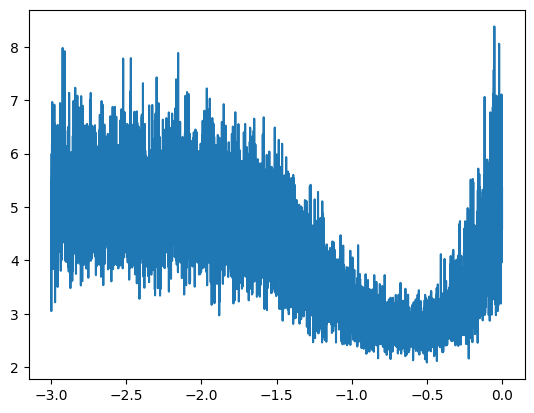

In [ ]:
plt.plot(lri,lossi)

- Visually we can see that from **point 0.5** on the x-axis we have a **good learning rate**.. from 0.5 upwards it seems that error **starts to gain to increase again**

In [ ]:
# forward pass
emb=C[X] # (32,3,2)
h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
logits=h @ w2+b2 # (32,27)
loss=F.cross_entropy(logits,Y)
loss


tensor(4.8610, grad_fn=<NllLossBackward0>)

In [ ]:
lri=[]
lossi=[]

steps=10000
for  i in range(steps):

  ix=torch.randint(0,X.shape[0],(32,))
  # forward pass
  emb=C[X[ix]] # (32,3,2)
  h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
  logits=h @ w2+b2 # (32,27)
  loss=F.cross_entropy(logits,Y[ix])
  loss
  #print(f'loss:{loss.item()},epochs:{i+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  #lr=lrs[i]
  for p  in parameters:
    p.data+=-0.01*p.grad

    # strack stats
    #lri.append(lre[i])
    #lossi.append(loss.item())

In [ ]:
emb=C[X] # (32,3,2)
h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
logits=h @ w2+b2 # (32,27)
loss=F.cross_entropy(logits,Y)
loss

tensor(2.4682, grad_fn=<NllLossBackward0>)

# **9 - Splitting up the dataset into train/val/test splits and why**

In [ ]:
# training split, dev/validations split, test split
#80         ,       #10             ,      #10

In [ ]:
def build_dataset(words):

  X,Y=[],[]

  block_size=3
  context=[0]*block_size
  for w in words:
    for ch in w + '.':
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)
      context=context[1:] + [ix]

  X=torch.tensor(X)
  Y=torch.tensor(Y)
  print(X.shape,Y.shape)

  return X,Y

In [ ]:
import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))
Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,yte=build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
lri=[]
lossi=[]

steps=10000
for  i in range(steps):

  ix=torch.randint(0,Xtr.shape[0],(32,))
  # forward pass
  emb=C[Xtr[ix]] # (32,3,2)
  h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
  logits=h @ w2+b2 # (32,27)
  loss=F.cross_entropy(logits,Ytr[ix])
  loss
  #print(f'loss:{loss.item()},epochs:{i+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  #lr=lrs[i]
  for p  in parameters:
    p.data+=-0.01*p.grad

    # strack stats
    #lri.append(lre[i])
    #lossi.append(loss.item())

In [ ]:
emb=C[Xdev] # (32,3,2)
h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
logits=h @ w2+b2 # (32,27)
loss=F.cross_entropy(logits,Ydev)
loss

tensor(2.4470, grad_fn=<NllLossBackward0>)

#**10-Experiment: larger hidden layer**

In [ ]:
g=torch.Generator().manual_seed(2134563788) # for reproducibility
C=torch.randn([27,2],requires_grad=True)
w1=torch.randn([6,300],requires_grad=True)
b1=torch.randn(300,requires_grad=True)
w2=torch.randn([300,27],requires_grad=True)
b2=torch.randn(27,requires_grad=True)
parameters=[C,w1,b1,w2,b2]

In [ ]:
lri=[]
lossi=[]
stepsi=[]

steps=40000
for  i in range(steps):

  ix=torch.randint(0,Xtr.shape[0],(32,))
  # forward pass
  emb=C[Xtr[ix]] # (32,3,2)
  h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
  logits=h @ w2+b2 # (32,27)
  loss=F.cross_entropy(logits,Ytr[ix])
  loss
  #print(f'loss:{loss.item()},epochs:{i+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  lr=0.5
  for p  in parameters:
    p.data+=-lr*p.grad

  # strack stats
  lossi.append(loss.item())
  stepsi.append(i)

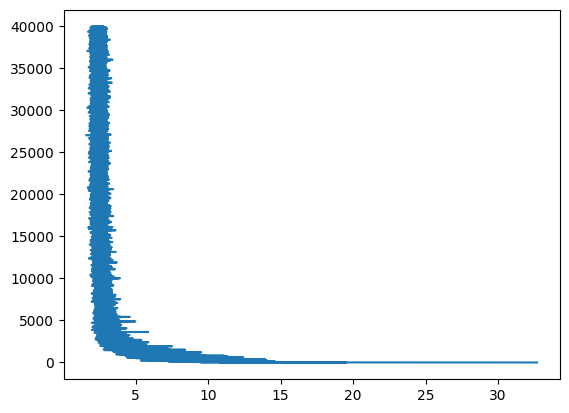

In [ ]:
plt.plot(lossi,stepsi)

In [ ]:
emb=C[Xdev] # (32,3,2)
h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
logits=h @ w2+b2 # (32,27)
loss=F.cross_entropy(logits,Ydev)
loss

tensor(2.4150, grad_fn=<NllLossBackward0>)

# **11- visualizing the character embeddings**

In [ ]:
C[Xtr[0,0]]

tensor([-1.2740,  1.9163], grad_fn=<SelectBackward0>)

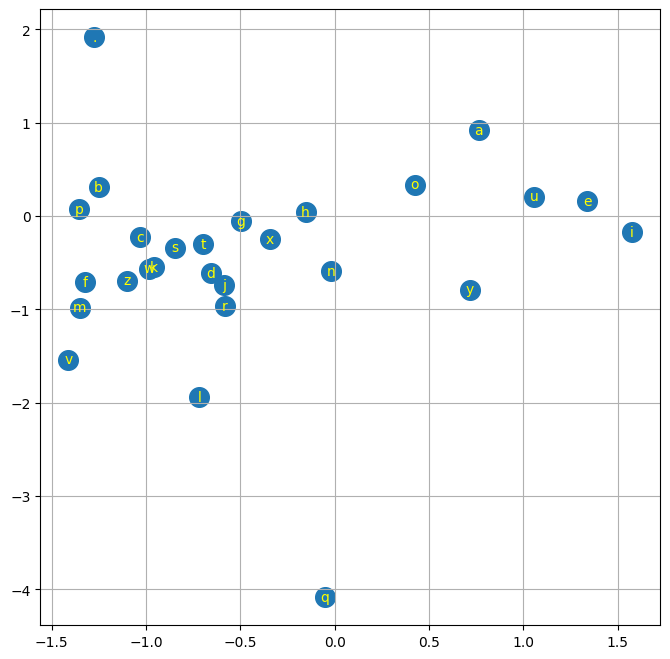

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha='center',va='center',color='yellow')
plt.grid('minor')

# **12-Experiment: larger embedding size**

In [ ]:
g=torch.Generator().manual_seed(2134563788) # for reproducibility
C=torch.randn([27,10],requires_grad=True)
w1=torch.randn([30,200],requires_grad=True)
b1=torch.randn(200,requires_grad=True)
w2=torch.randn([200,27],requires_grad=True)
b2=torch.randn(27,requires_grad=True)
parameters=[C,w1,b1,w2,b2]

In [ ]:
sum(i.nelement() for i in parameters)

11897

In [ ]:
lri=[]
lossi=[]
stepsi=[]

In [ ]:
steps=40000
for  i in range(steps):

  ix=torch.randint(0,Xtr.shape[0],(32,))
  # forward pass
  emb=C[Xtr[ix]] # (32,3,2)
  h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
  logits=h @ w2+b2 # (32,27)
  loss=F.cross_entropy(logits,Ytr[ix])
  loss
  #print(f'loss:{loss.item()},epochs:{i+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  lr=0.01
  for p  in parameters:
    p.data+=-lr*p.grad

    # strack stats
  stepsi.append(i)
  lossi.append(loss.log10().item())

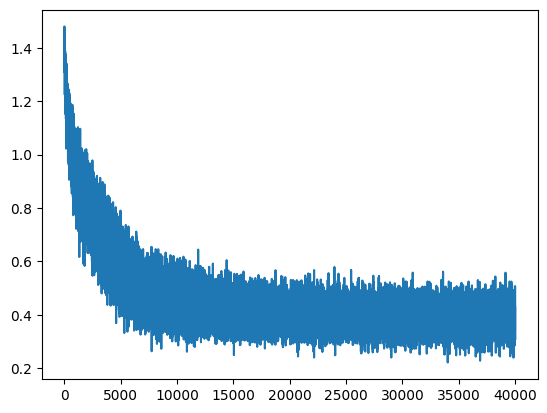

In [ ]:
plt.plot(stepsi,lossi)

In [ ]:
emb=C[Xtr] # (32,3,2)
h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
logits=h @ w2+b2 # (32,27)
loss=F.cross_entropy(logits,Ytr)
loss

tensor(2.4575, grad_fn=<NllLossBackward0>)

In [ ]:
emb=C[Xdev] # (32,3,2)
h=torch.tanh(emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) @ w1+b1) # (32,100)
logits=h @ w2+b2 # (32,27)
loss=F.cross_entropy(logits,Ydev)
loss

tensor(2.4562, grad_fn=<NllLossBackward0>)

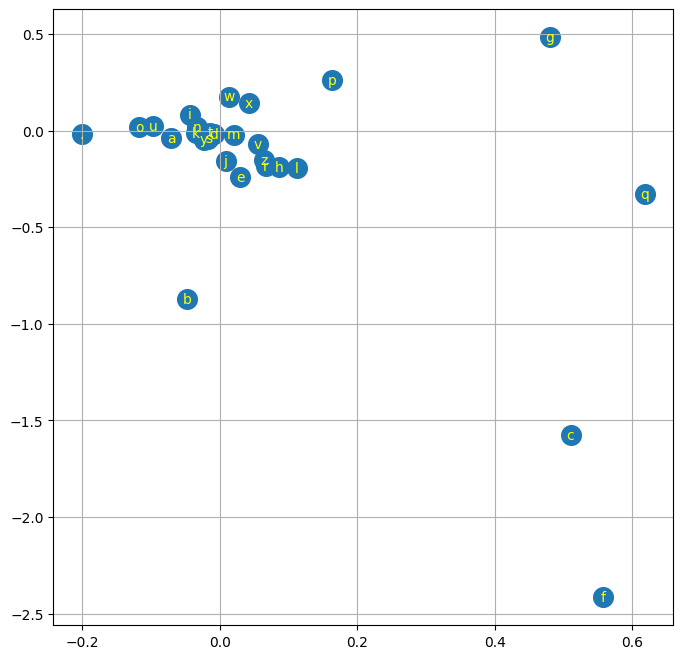

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0],C[i,1],itos[i],ha='center',va='center',color='yellow')

plt.grid('minor')

# **13-Sampling from the model**

In [ ]:
g=torch.Generator().manual_seed(2147483647+10)

for _  in range(20):
  out = []

  context=[0] * block_size

  while True:
    emb=C[torch.tensor([context])]
    h=torch.tanh(emb.view(1,-1) @ w1+b1)
    logits=h @ w2+b2
    y_pred=F.softmax(logits,dim=1)
    ix=torch.multinomial(y_pred,num_samples=1,replacement=True,generator=g).item()
    context=context[1:] + [ix]
    out.append(ix)
    if ix ==0:
      break
  print(''.join(itos[i] for i in out))


bria.
mmyan.
dee.
ved.
ryah.
bethan.
bri.
bri.
aden.
daelii.
brizaen.
ddennesonnar.
vayzimtokelin.
shuber.
dhi.
bel.
vin.
rweel.
pxnt.
porou.
